In [15]:
# Reload magic
%reload_ext autoreload
%autoreload 2

In [16]:
import anndata as ad
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import scanpy as sc
from tqdm import tqdm

import spacetime
from spacetime import potentials, steps

## Create data

In [17]:
# define a Styblinski potential
def styblinski(x):
    return jnp.sum(x**4 - 16 * x**2 + 5 * x) / 2

In [18]:
# Create a gaussian point cloud and follow an Euler-Maruyama trajectory.
n_timepoints, n, dt = 5, 1_000, 0.06
key = jax.random.PRNGKey(0)

gaussians_key, key = jax.random.split(key)
x = 0.5 * jax.random.normal(gaussians_key, (n, 2))
populations = [x.copy()]

for i in range(n_timepoints - 1):
    x -= dt * jax.vmap(jax.grad(styblinski))(x)
    populations.append(x.copy())

In [19]:
# Create an AnnData object with the gaussians.
adata = ad.AnnData(
    np.concatenate(populations),
    obs={"timepoint": np.repeat(np.arange(n_timepoints), n)},
)

In [20]:
# Compute a PCA on the data.
adata.obsm["X_pca"] = adata.X

# Normalize the data.
adata.obsm["X_pca"] = adata.obsm["X_pca"] / adata.obsm["X_pca"].max()

## Train model

In [21]:
model = spacetime.SpaceTime(balancedness=0.9)

In [22]:
# Fit the model.
model.fit(
    adata, time_obs="timepoint", x_obsm="X_pca", space_obsm="X_pca", batch_size=100
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Train (# cells):  [800, 800, 800, 800, 800]
Val (# cells):  [200, 200, 200, 200, 200]


  6%|▌         | 572/10000 [00:51<14:08, 11.11it/s, iteration=573, train_loss=0.078613855, val_loss=0.104101226]

Met early stopping criteria, breaking...


## Display the predictions

In [23]:
# Plot the energy landscape.
potential_fn = lambda x: model.potential.apply(model.params, x)

# Create a grid.
x = jnp.linspace(-2.5, 2.5, 100)
y = jnp.linspace(-2.5, 2.5, 100)
xx, yy = jnp.meshgrid(x, y)
grid = jnp.stack([xx.flatten(), yy.flatten()], axis=1)

# Compute the energy on the grid.
energy = jax.vmap(potential_fn)(grid)

In [24]:
adata.obsm["X_pred"] = adata.obsm["X_pca"].copy()
for i in tqdm(range(n_timepoints)):
    idx = adata.obs["timepoint"] == i
    adata.obsm["X_pred"][idx] = model.transform(adata[idx], x_obsm="X_pca")

100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


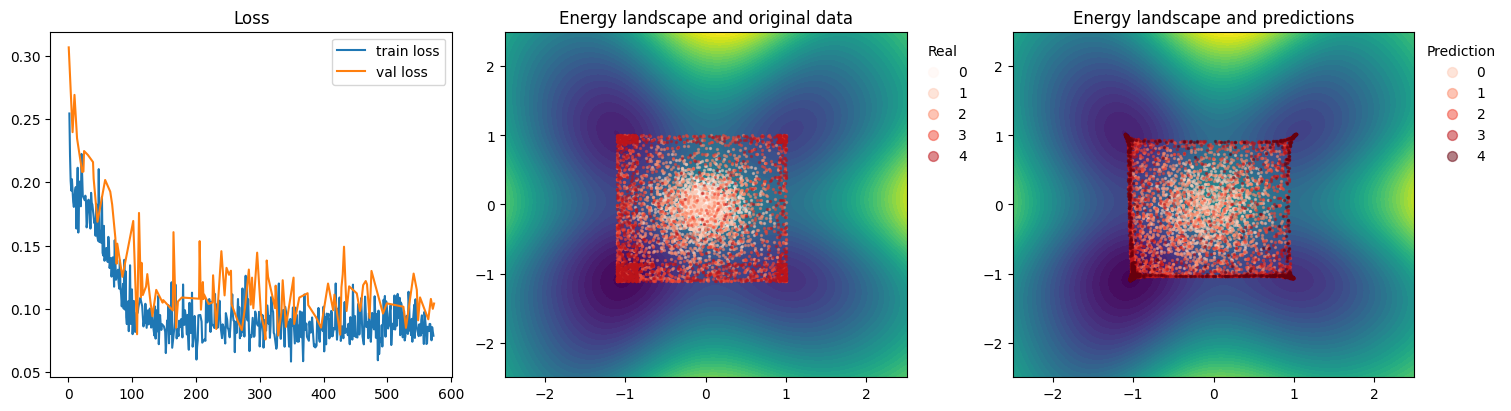

In [25]:
# Plot the data, with a legend for the timepoints, color with Reds.
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

axes[0].plot(model.train_it, model.train_losses, label="train loss")
axes[0].plot(model.val_it, model.val_losses, label="val loss")
axes[0].set_title("Loss")
axes[0].legend()

# Plot the energy.
axes[1].contourf(xx, yy, energy.reshape(xx.shape), levels=50)
axes[2].contourf(xx, yy, energy.reshape(xx.shape), levels=50)

# Plot the data, with a legend for the timepoints, color with Reds.
for i in range(n_timepoints):
    axes[1].scatter(
        adata.obsm["X_pca"][adata.obs["timepoint"] == i, 0],
        adata.obsm["X_pca"][adata.obs["timepoint"] == i, 1],
        label=i,
        s=2,
        alpha=0.5,
        color=plt.cm.Reds(i / n_timepoints),
    )
    axes[2].scatter(
        adata.obsm["X_pred"][adata.obs["timepoint"] == i, 0],
        adata.obsm["X_pred"][adata.obs["timepoint"] == i, 1],
        label=i,
        s=2,
        alpha=0.5,
        color=plt.cm.Reds((i + 1) / n_timepoints),
    )
# Legend with larger dots.
axes[1].legend(
    title="Real", bbox_to_anchor=(1, 1), loc="upper left", frameon=False, markerscale=5
)
axes[2].legend(
    title="Prediction",
    bbox_to_anchor=(1, 1),
    loc="upper left",
    frameon=False,
    markerscale=5,
)
axes[1].set_title("Energy landscape and original data")
axes[2].set_title("Energy landscape and predictions")
plt.show()

In [26]:
assert np.min(model.train_losses) < 1e-1